This is a notebook for the regesion model, 2.iv 

###  General Idea

> **“As a group, how much of a gene’s expression variation across cell types can be **explained by** the accessibility of its candidate CREs?”**

Concretely, for each gene you’ll:

1. **Gather predictors**  
   – All your ATAC-seq peaks (CREs) linked to that gene (e.g. ±20 kb around its TSS or however you defined your peak→gene map).  
   – For each of these peaks, you already have a vector of accessibility values across N cell types.

2. **Gather response**  
   – The same gene’s expression levels across those N cell types.

3. **Fit a linear model**  
   –  where  
     - **Y** is the N-vector of gene expression,  
     - **X** is the N×P matrix of peak-accessibility (one column per CRE),  
     - **β** are the coefficients.  
     – Compute **R²** to see “what fraction of variance in Y is captured by X.”

4. **Inspect coefficients**  
   – Which CREs get large positive (activating) or negative (repressing) **β**?


In [2]:
import pandas as pd

# 1) Load the full table
atac = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv", index_col=False)

# 2) See exactly which columns it contains
print(atac.columns.tolist())

# (Optional) peek at the first few rows
atac.head()


['ImmGenATAC1219.peakID', 'chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM']


,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,preT.DN1.Th,preT.DN2a.Th,...,T8.Tcm.LCMV.d180.Sp,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM
0,ImmGenATAC1219.peak_1,chr1,3020786,0.00,0.56,NaN,NaN,NaN,0.11,0.77,...,0.71,2.78,0.56,0.11,0.64,1.14,0.41,0.71,0.90,0.11
1,ImmGenATAC1219.peak_2,chr1,3087226,0.00,0.50,NaN,NaN,NaN,0.77,0.77,...,0.94,3.56,0.98,2.12,0.12,0.11,0.41,1.64,0.90,0.83
2,ImmGenATAC1219.peak_3,chr1,3120109,0.07,10.80,1.0,NaN,NaN,0.40,0.77,...,1.32,2.79,0.56,1.72,0.12,0.11,2.36,0.10,0.90,0.11
3,ImmGenATAC1219.peak_4,chr1,3121485,0.15,3.02,1.0,NaN,NaN,0.46,0.11,...,3.41,0.11,2.86,0.11,0.64,2.20,0.41,0.10,0.11,0.11
4,ImmGenATAC1219.peak_5,chr1,3372787,0.03,1.31,NaN,NaN,NaN,0.77,0.84,...,0.94,0.11,1.59,0.51,0.12,0.53,0.41,0.10,0.11,0.11


In [5]:
import pandas as pd

# 1) load and rename the peak‐ID column
atac = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")
atac = atac.rename(columns={"ImmGenATAC1219.peakID": "peak_id"})

# 2) list exactly the metadata columns you want to remove
to_drop = [
    "chrom",
    "Summit",
    "mm10.60way.phastCons_scores",
    "_-log10_bestPvalue",
    "Included.in.systematic.analysis",
    "TSS",
    "genes.within.100Kb",
]

# 3) drop them, keeping peak_id + everything else
atac_sub = atac.drop(columns=to_drop)

# 4) confirm
print(atac_sub.columns.tolist())
atac_sub.head()


['peak_id', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM']


,peak_id,preT.DN1.Th,preT.DN2a.Th,preT.DN2b.Th,preT.DN3.Th,T.DN4.Th,T.ISP.Th,T.DP.Th,T.4.Th,T.8.Th,...,T8.Tcm.LCMV.d180.Sp,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM
0,ImmGenATAC1219.peak_1,0.11,0.77,0.51,0.49,0.58,0.11,0.67,0.11,1.09,...,0.71,2.78,0.56,0.11,0.64,1.14,0.41,0.71,0.90,0.11
1,ImmGenATAC1219.peak_2,0.77,0.77,0.47,1.56,1.02,0.11,0.73,0.91,0.53,...,0.94,3.56,0.98,2.12,0.12,0.11,0.41,1.64,0.90,0.83
2,ImmGenATAC1219.peak_3,0.40,0.77,0.11,0.10,0.35,0.53,1.08,0.11,0.11,...,1.32,2.79,0.56,1.72,0.12,0.11,2.36,0.10,0.90,0.11
3,ImmGenATAC1219.peak_4,0.46,0.11,0.47,0.10,0.58,0.11,0.17,2.15,0.53,...,3.41,0.11,2.86,0.11,0.64,2.20,0.41,0.10,0.11,0.11
4,ImmGenATAC1219.peak_5,0.77,0.84,1.34,1.69,0.34,0.94,0.40,0.39,0.54,...,0.94,0.11,1.59,0.51,0.12,0.53,0.41,0.10,0.11,0.11


In [8]:
import pandas as pd

# 1) Load without an index
atac = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")

# 2) Rename your peak‐ID column
atac = atac.rename(columns={"ImmGenATAC1219.peakID": "peak_id"})

# 3) Drop any leftover metadata if you haven’t yet
to_drop = [
    "chrom", "Summit", "mm10.60way.phastCons_scores",
    "_-log10_bestPvalue", "Included.in.systematic.analysis",
    "TSS", "genes.within.100Kb",
]
atac_sub = atac.drop(columns=to_drop)

# 4) Now set the index
atac_sub = atac_sub.set_index("peak_id")

# 5) Quick check
print("ATAC shape:", atac_sub.shape)
atac_sub.head()


ATAC shape: (512595, 29)


,preT.DN1.Th,preT.DN2a.Th,preT.DN2b.Th,preT.DN3.Th,T.DN4.Th,T.ISP.Th,T.DP.Th,T.4.Th,T.8.Th,T.4.Nve.Sp,...,T8.Tcm.LCMV.d180.Sp,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM
peak_id,,,,,,,,,,,,,,,,,,,,,
ImmGenATAC1219.peak_1,0.11,0.77,0.51,0.49,0.58,0.11,0.67,0.11,1.09,3.23,...,0.71,2.78,0.56,0.11,0.64,1.14,0.41,0.71,0.90,0.11
ImmGenATAC1219.peak_2,0.77,0.77,0.47,1.56,1.02,0.11,0.73,0.91,0.53,0.84,...,0.94,3.56,0.98,2.12,0.12,0.11,0.41,1.64,0.90,0.83
ImmGenATAC1219.peak_3,0.40,0.77,0.11,0.10,0.35,0.53,1.08,0.11,0.11,2.04,...,1.32,2.79,0.56,1.72,0.12,0.11,2.36,0.10,0.90,0.11
ImmGenATAC1219.peak_4,0.46,0.11,0.47,0.10,0.58,0.11,0.17,2.15,0.53,1.25,...,3.41,0.11,2.86,0.11,0.64,2.20,0.41,0.10,0.11,0.11
ImmGenATAC1219.peak_5,0.77,0.84,1.34,1.69,0.34,0.94,0.40,0.39,0.54,1.89,...,0.94,0.11,1.59,0.51,0.12,0.53,0.41,0.10,0.11,0.11


In [12]:
import pandas as pd

# 1) Load without setting an index
rna = pd.read_csv("RNA-seq/filtered_RNA_abT_Tact_Stem.csv")

# Rename and index
rna = (
    rna
    .rename(columns={"Unnamed: 0": "gene_symbol"})
    .set_index("gene_symbol")
)

# Confirm
print(rna.shape)
rna.head()


(17535, 29)


,preT.DN1.Th,preT.DN2a.Th,preT.DN2b.Th,preT.DN3.Th,T.DN4.Th,T.ISP.Th,T.DP.Th,T.4.Th,T.8.Th,T.4.Nve.Sp,...,T8.Tcm.LCMV.d180.Sp,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM
gene_symbol,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,1.022363,1.389747,1.024819,1.024482,1.026430,1.026217,3.010920,1.024462,1.024819,2.726341,...,1.025833,1.024819,1.385805,1.025833,1.575395,1.024819,1.096732,1.096732,1.021750,1.021812
0610007P14Rik,162.641117,206.945221,209.187788,198.421365,215.056475,225.565360,73.904647,138.841383,139.863904,168.924363,...,206.241084,205.309922,165.690720,133.234920,127.894194,195.147548,206.053987,246.105317,192.424636,204.298358
0610009B22Rik,68.070719,82.468806,89.769337,57.661619,76.399214,84.671456,32.828651,27.207241,36.169759,32.753248,...,36.105700,34.348965,25.168975,33.305724,29.284365,33.322384,78.272059,78.837030,68.844751,76.418169
0610009L18Rik,15.450717,13.573968,14.427620,8.249482,1.683173,4.001953,5.595954,6.367369,6.505833,8.262234,...,8.645607,7.268431,3.840215,1.025833,6.283540,12.791348,8.577159,16.791386,15.511549,16.947354
0610009O20Rik,160.246297,125.475307,155.928005,120.692893,118.433597,149.630866,92.040668,76.781112,87.529814,86.523573,...,87.608325,56.128251,109.175415,91.992319,102.035627,108.414405,168.645852,157.926022,155.941641,186.261464


In [15]:

# 3) Load your peak→gene annotation
annot = pd.read_csv("peak_to_gene_annotated.csv")

# Quick checks
print("ATAC shape:", atac_sub.shape)
print("RNA  shape:",  rna.shape)
print("Annot shape:", annot.shape)

ATAC shape: (512595, 29)
RNA  shape: (17535, 29)
Annot shape: (14859136, 10)


In [16]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# 1) Your gene
gene = "0610005C13Rik"

# 2) Response vector Y
Y = rna.loc[gene]

# 3) Predictor matrix X: all peaks linked to that gene
peaks = annot.loc[annot.gene_symbol == gene, "peak_id"].tolist()
X = atac_sub.loc[peaks].T

# 4) Fit and report R²
model = LinearRegression().fit(X, Y)
print(f"{gene} R² = {model.score(X, Y):.3f}")

# 5) Top 5 strongest CREs by |β|
coefs = pd.Series(model.coef_, index=X.columns).abs().nlargest(5)
print("Top 5 CREs by |β|:\n", coefs)


0610005C13Rik R² = 0.183
Top 5 CREs by |β|:
 peak_id
ImmGenATAC1219.peak_427239    5.747318e+12
ImmGenATAC1219.peak_427235    3.944051e+12
ImmGenATAC1219.peak_427236    3.125048e+12
ImmGenATAC1219.peak_427237    2.711480e+12
ImmGenATAC1219.peak_427240    2.634922e+12
dtype: float64


In [20]:
from sklearn.linear_model import LinearRegression
import pandas as pd

r2_results = {}

for gene in rna.index:
    # 1) Get the list of peaks linked to this gene
    peaks = annot.loc[annot.gene_symbol == gene, "peak_id"].tolist()
    # 2) Skip if no peaks
    if len(peaks) == 0:
        r2_results[gene] = None
        continue

    # 3) Build X and Y
    X = atac_sub.loc[peaks].T        # shape: (29 cell types × P peaks)
    Y = rna.loc[gene]                # shape: (29 cell types,)

    # 4) Fit and record R²
    model = LinearRegression().fit(X, Y)
    r2_results[gene] = model.score(X, Y)

# 5) Turn into a sorted Series
r2_series = pd.Series(r2_results, name="R2").dropna().sort_values(ascending=False)

# 6) Quick summary
print("Genes covered:", len(r2_series))
print(r2_series.describe())

# (Optional) peek at the top / bottom
print("\nTop 5 R² genes:\n", r2_series.head())
print("\nBottom 5 R² genes:\n", r2_series.tail())


Genes covered: 16606
count    16606.000000
mean         0.129681
std          2.802047
min       -196.772761
25%          0.041114
50%          0.409677
75%          1.000000
max          1.000000
Name: R2, dtype: float64

Top 5 R² genes:
 Sipa1l3    1.0
Lyrm2      1.0
Coq2       1.0
Htra3      1.0
Lypd6b     1.0
Name: R2, dtype: float64

Bottom 5 R² genes:
 Mov10     -67.856970
Tnk2      -70.342928
Sft2d3    -74.786445
Sema3e    -90.444611
St18     -196.772761
Name: R2, dtype: float64


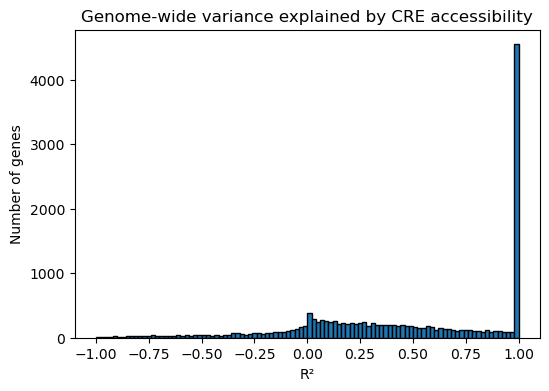

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(r2_series, bins=100, range=(-1,1), edgecolor='k')
plt.xlabel('R²')
plt.ylabel('Number of genes')
plt.title('Genome-wide variance explained by CRE accessibility')
plt.show()
